# Automatically labelling radiology reports

In [163]:
# Library imports

# General
import sys
import os
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from datetime import datetime

# NLP imports
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import re

# sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

# gensim for word embedding featurization
import gensim
from collections import namedtuple

# misc
import glob
import os.path
import multiprocessing
import random
import umap.umap_ as umap
import matplotlib.pyplot as plt


sys.path.append("C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\rad-report-annotator")
import RadReportAnnotator as ra
# pd.set_option('display.max_columns', None)

# dir(RadReportAnnotator) # list available functions

In [148]:
# Initialize some folder paths
reports = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\20080801 20190131 Neuro and SLAM MRI Heads.csv"
reports_path = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\Reports"

test_labels = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\output_test.xlsx"
binary_labels = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\output_binary_combined.xlsx"
labels_path = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\Labels"
figures_path = "C:\\Users\\marti\\Dropbox\\1. KCL\\1. Current Modules\\6. SPM\\1. Analysis\\NLP\\Data\\Figures"


labels = binary_labels # use either test_labels or binary_labels for now

In [3]:
# Create pandas dataframes
df_raw = pd.read_csv(reports,encoding = "ISO-8859-1", dtype={"Code": 'O',}) # Column 17 "Code" reports a mixed value error on import without specifying it as Python Object 
df_labels = pd.read_excel(labels) 

In [4]:
# Remove NaN, <18 yo, and brief reports.
df_raw = df_raw[~df_raw["Report Text"].isnull()] # remove the lines with missing reports
df_raw = df_raw[~df_raw['DOB'].isnull()] # remove missing DOB
df_raw = df_raw[df_raw['Report Text'].map(len) > 10] # report length greater than X
df_raw = df_raw[(df_raw['Event Year'].astype(int) - df_raw['DOB'].str[-4:].astype(int))>18] #
df_raw = df_raw.reset_index()

#df_raw.head()
# dob_mask.head(50)

In [5]:
# Replicate the format of Sinai data, but use csv - this means we can't use all of their code
# Sinai code uses XLS, so would have to cap df_raw_filter to some smaller subset

# print(df_raw.columns)
df_raw_filter = df_raw.loc[:,["Accession", "Report Text"]]
df_raw_filter.columns=["Accession Number", "Report Text"]
df_raw_filter.to_csv(reports_path+'\\raw_data_filtered.csv',header = True, index = False)
reports_filter = reports_path+'\\raw_data_filtered.csv'


In [6]:
filter_columns = [' Accession ', ' Fazekas ', ' Supratentorial Atrophy ',
        ' Infratentorial Atrophy ', ' Mass ', ' Vascular ', ' Damage ',
        ' Acute Stroke ', ' Haemorrhage ', ' Hydrocephalus ',
        ' White Matter Inflammation ', ' Foreign Body ', ' Intracranial ',
        ' Extracranial '] # select accession and other variables
df_labels_filter = df_labels[filter_columns] 
df_labels_filter = df_labels_filter.rename(columns = {' Accession ':'Accession Number'}) # rename to match the other file

# We can use excel for this one bc # of labels will always < 65k. Also, build_train_test_corpus requires xls
# df_labels_filter["Accession Number"] = df_labels_filter.loc[:,"Accession Number"].str[3:]
df_labels_filter.to_excel(labels_path+'\\labels_filtered.xls',header = True, index = False)
labels_filter = labels_path+'\\labels_filtered.xls'

In [7]:
# this is a replacement of the get_label_indeces function
# ra.get_labeled_indices(reports_path, labels_filter, train_index_override)
label_ids = df_labels_filter['Accession Number']
mask_labels = df_raw_filter['Accession Number'].isin(label_ids.tolist()) # true/false for the ones in the list

In [8]:
# Create a list of stopwords and process data
stop_words = set(stopwords.words('english')) # could add MRI etc to this
preprocessed = ra.preprocess_data(df_raw_filter,stop_words)

  0%|                                             | 30/108602 [00:00<06:04, 297.83it/s]

preprocessing reports


100%|█████████████████████████████████████████| 108602/108602 [03:21<00:00, 537.91it/s]


## Process the data

In [9]:
# Create n-grams  
N_THRESH_CORPUS = 3 # ignore any n-grams that appear fewer than N times in the entire corpus
n_gram_sizes = [1,2,3,4] # need to make sure we can use 4 - their examples are 3 max 
ngram_list = ra.create_ngrams(preprocessed, mask_labels, n_gram_sizes, N_THRESH_CORPUS)

## notes from david: set n_gram = 1 for gensim
## The very last bit of this code takes forever - figure out why

  0%|▏                                          | 326/108602 [00:00<00:33, 3236.58it/s]

creating n-grams


100%|████████████████████████████████████████| 108602/108602 [00:27<00:00, 3969.18it/s]


number of unique n-grams: 4282825
number of unique n-grams after filtering out low frequency tokens: 561735


In [10]:
# Split the sets for training & testing
# Note that this function requires xls for label file
# This can take a while - could add an indicator in the future

TRAIN_INDEX_OVERRIDE = [0] # This would be a list of indices for which to ignore the labels if all of the training data was labelled
corpus, train_corpus, test_corpus, dictionary, labeled_indices = ra.build_train_test_corpus(df_raw_filter, ngram_list, labels_filter, TRAIN_INDEX_OVERRIDE)


# SORT THIS OUT?

In [11]:
# I'm pretty sure "d2v_inputs" is the same as "preprocessed" but generate_labeled_data_features requires both,
# and I can't really tell how they're different

d2v_inputs = ra.remove_infrequent_tokens(preprocessed, N_THRESH_CORPUS, mask_labels)

In [12]:
# Create training sets
unlabeled_corpus, labeled_corpus, total_unlabeled_words = ra.build_d2v_corpora(df_raw_filter, preprocessed,labeled_indices)

106610 unlabeled reports for featurization, 1992 labeled reports for modeling


In [13]:
# Establish variables
D2V_EPOCHS = 20 # recommended by Sinai
DIM_DOC2VEC = 50 # Dimensionality of doc2vec manifold; recommend value in 50 to 400
W2V_DM = 1
W2V_WINDOW = 3
SILVER_THRESHOLD = "mean" # can be ["mean","mostlikely"]
DO_PARAGRAPH_VECTOR = False # True to use word2vec-based paragraph vector embedding fatures
DO_BOW = False
DO_WORD2VEC = True # True to use word2vec-based average word embedding fatures
N_THRESH_OUTCOMES = 1 # do not train models for labels that don't have at least this many positive and negative examples
pred_type = "combined" # a label for results
ASSIGNFOLD_USING_ROW=False
SILVER_THRESHOLD="fiftypct"

# Initiate the class based on demo notebookhttps://github.com/aisinai/rad-report-annotator/blob/master/RadReportAnnotator.py
# MRIannotator = ra.RadReportAnnotator(report_dir_path=os.path.join(reports_path),validation_file_path=os.path.join(labels_filter))
 # MRIannotator.define_config(DO_BOW=True,
#                            DO_WORD2VEC=False,
#                            DO_PARAGRAPH_VECTOR=False,
#                            N_GRAM_SIZES=[1,2,3],
#                            SILVER_THRESHOLD="fiftypct",
#                            NAME_UNID_REPORTS = "ACCID",
#                            NAME_TEXT_REPORTS ="REPORT",
#                            N_THRESH_CORPUS=10,
#                            N_THRESH_OUTCOMES=50)

In [14]:
def train_d2v(unlabeled_docs, labeled_docs, D2V_EPOCH, DIM_DOC2VEC, W2V_DM, W2V_WINDOW, total_unlabeled_words):
	"""
	Train doc2vec/word2vec model.
	Args:
		unlabeled_docs: unlabeled corpus
		labeled_docs: labeled corpus
		D2V_EPOCHS: number of epochs to train d2v model; 20 has worked well in our experiments; parameter for gensim doc2vec
		DIM_DOC2VEC: dimensionality of embedding vectors, we explored values 50-800; parameter for gensim doc2vec
		W2V_DM: 1 is PV-DM, otherwise PV-DBOW; parameter for gensim doc2vec
		W2V_WINDOW: number of words window to use  in doc2vec model; parameter for gensim doc2vec
		total_unlabeled_words: total words in unlabeled corpus; argument for gensim doc2vec
	Returns:
		d2vmodel: trained doc2vec model.
	"""

	cores = multiprocessing.cpu_count()
	assert gensim.models.doc2vec.FAST_VERSION > -1, "speed up"
	print("started doc2vec training")
	d2vmodel = gensim.models.Doc2Vec(dm=W2V_DM, size=DIM_DOC2VEC, window=W2V_WINDOW, negative=5, hs=0, min_count=2, workers=cores)
	d2vmodel.build_vocab(unlabeled_docs + labeled_docs)  
	d2vmodel.train(unlabeled_docs, total_words=total_unlabeled_words, epochs=D2V_EPOCH)
	print("finished doc2vec training")
	return d2vmodel

In [15]:
# Train
d2vmodel = train_d2v(unlabeled_corpus, labeled_corpus, D2V_EPOCHS, DIM_DOC2VEC, 
                        W2V_DM, W2V_WINDOW, total_unlabeled_words)

started doc2vec training


c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


finished doc2vec training


In [16]:
# Create features for Lasso log reg
bow_matrix, pv_matrix, w2v_matrix, accid_list, orig_text, orig_input = ra.generate_labeled_data_features(labels_filter,labeled_indices,DIM_DOC2VEC, df_raw_filter,  
                                                                                                         preprocessed, DO_PARAGRAPH_VECTOR, DO_WORD2VEC, dictionary, 
                                                                                                         corpus, d2vmodel, d2v_inputs)


  0%|▏                                                | 6/1992 [00:00<00:34, 56.76it/s]

generating features


100%|█████████████████████████████████████████████| 1992/1992 [00:11<00:00, 167.04it/s]


In [29]:
# Generate dataframe of labels to be used in Lasso logistic regressions
# EDITED range in for loop to skip the IDs as variables; removed IDs right after loop
def generate_outcomes(labeled_file, accid_list, N_THRESH_OUTCOMES):

    """
    Generate dataframe of labels to be used in Lasso logistic regressions
    Args:
        labeled_file: path to file with labels and accession ids
        accid_list: list of accession ids of each row in the labeled data that are also present in exported reports; 
                    needed to eliminate labeled reports for which we have no text (mistranscribed accession IDs, etc.)
        N_THRESH_OUTCOMES: eliminate outcomes that don't have this many positive / negative examples
    Returns:
        eligible_outcomes_aligned: dataframe of labels eligible for prediction
        all_outcomes_aligned: dataframe of all labels
        N_LABELS: total number of labels we predict
        outcome_header_list: list of headers corresponding to each label
    """    
    outcomes = pd.read_excel(labeled_file)
    outcomes.set_index('Accession Number')
    outcomes_aligned2 = pd.DataFrame(data=accid_list, index=accid_list, columns=['Accession Number'])
    all_outcomes_aligned = pd.merge(outcomes_aligned2, outcomes, sort=False)

    N_LABELS = all_outcomes_aligned.shape[1]
    outcome_remove=[]
    print('total labels:'+str(N_LABELS))

    for i in range(1,N_LABELS): #start from 1 to skip the IDs
        check=sum(all_outcomes_aligned.iloc[:,i])

        if(check<N_THRESH_OUTCOMES):
            outcome_remove.append(i)
        elif(check>((all_outcomes_aligned.shape)[0]-N_THRESH_OUTCOMES)):
            outcome_remove.append(i)
        elif(math.isnan(check)):
            outcome_remove.append(i)

    outcome_remove.append(0) # added this to remove the accession IDs as "outcomes"
    eligible_outcomes_aligned=all_outcomes_aligned.drop(all_outcomes_aligned.columns[outcome_remove],axis=1)

    N_LABELS=eligible_outcomes_aligned.shape[1]
    print("labels eligible for inference:"+str(N_LABELS))

    outcome_header_list=list(eligible_outcomes_aligned)
    outcome_header_list=[x.replace(",",".") for x in outcome_header_list]
    outcome_header_list=",".join(outcome_header_list)

    return eligible_outcomes_aligned,all_outcomes_aligned, N_LABELS, outcome_header_list

In [30]:
# Create input for Lasso
eligible_outcomes_aligned, all_outcomes_aligned, N_LABELS, outcome_header_list = generate_outcomes(labels_filter, 
                                                                                              accid_list, N_THRESH_OUTCOMES)

total labels:14
labels eligible for inference:1


In [31]:
# initiate predictor_matrix before generating silver standard labels -- use whatever features are generated (word2vec average word embeddings, bow features, paragraph vector matrix)
if(DO_BOW and DO_WORD2VEC and DO_PARAGRAPH_VECTOR): combined=np.hstack((bow_matrix,w2v_matrix,pv_matrix))

if(DO_BOW and DO_WORD2VEC and not DO_PARAGRAPH_VECTOR): combined=np.hstack((bow_matrix,w2v_matrix))
if(DO_BOW and not DO_WORD2VEC and DO_PARAGRAPH_VECTOR): combined=np.hstack((bow_matrix,pv_matrix))
if(not DO_BOW and DO_WORD2VEC and DO_PARAGRAPH_VECTOR): combined=np.hstack((w2v_matrix,pv_matrix))

if(DO_BOW and not DO_WORD2VEC and not DO_PARAGRAPH_VECTOR): combined=bow_matrix
if(not DO_BOW and DO_WORD2VEC and not DO_PARAGRAPH_VECTOR): combined=w2v_matrix
if(not DO_BOW and not DO_WORD2VEC and DO_PARAGRAPH_VECTOR): combined=pv_matrix		

predictor_matrix = combined

headers=[]
if(DO_BOW): 				headers=headers + [dictionary[i] for i in dictionary]
if(DO_WORD2VEC): 			headers=headers + ["W2V"+str(i) for i in range(0,DIM_DOC2VEC)]
if(DO_PARAGRAPH_VECTOR): 	headers=headers + ["PV"+str(i) for i in range(0,DIM_DOC2VEC)]
    

In [68]:
#export matrices for graphing
# np.savetxt(reports_path+'w2v_matrix_1',w2v_matrix,delimiter=',')
# pd.DataFrame(w2v_matrix).to_csv(reports_path+'\\w2v_matrix_2.csv',header = True, index = False)
# eligible_outcomes_aligned.to_csv(reports_path+'\\eligible_outcomes_aligned.csv',header= True, index = False)


# Simplified classifier

In [212]:
# do a short test of the classifiers

X = w2v_matrix
Y = eligible_outcomes_aligned.to_numpy(dtype=int) # [' Mass '].tolist()
Y = Y.ravel()

# this should become dynamic eventually
n_classes = 1
test_size = 0.2

X_train, X_holdout, Y_train, Y_holdout =  train_test_split(X, Y, test_size = test_size)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = test_size)


parameters = { "penalty": ['l2'], 
           "C": [64,32,16,8,4,2,1,0.5,0.25,0.1,0.05,0.025,0.01,0.005]}


cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(LogisticRegression(solver='lbfgs'), param_grid=parameters, scoring='neg_log_loss', cv=cv)
grid_search.fit(X_train,np.array(Y_train))				
best_parameters0 = grid_search.best_estimator_.get_params()
classifier = LogisticRegression(**best_parameters0)	

# classifier = LogisticRegression(solver='liblinear')


# Test on self 
Y_score_test = classifier.fit(X_train, Y_train).decision_function(X_test)
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()

for i in range(n_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(Y_test, Y_score_test)
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])


# Test on holdout
Y_score_holdout = classifier.fit(X_train, Y_train).decision_function(X_holdout)
fpr_holdout = dict()
tpr_holdout = dict()
roc_auc_holdout = dict()


for i in range(n_classes):
    fpr_holdout[i], tpr_holdout[i], _ = roc_curve(Y_holdout, Y_score_holdout)
    roc_auc_holdout[i] = auc(fpr_holdout[i], tpr_holdout[i])

    
probs_test = classifier.predict_proba(X_test)[:,1]
probs_holdout = classifier.predict_proba(X_holdout)[:,1]

threshold = 0.5
preds_test = probs_test>threshold
preds_holdout = probs_holdout>threshold

accuracy_test = (preds_test == Y_test).sum()/len(Y_test)
accuracy_holdout = (preds_holdout == Y_holdout).sum()/len(Y_holdout)

print('Test accuracy =',accuracy_test)
print('Holdout accuracy =',accuracy_holdout)
print('Test ROC =', roc_auc_test)
print('Holdout ROC =', roc_auc_holdout)


# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_holdout.ravel(), Y_score_holdout.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceW

Test accuracy = 0.9247648902821317
Holdout accuracy = 0.8922305764411027
Test ROC = {0: 0.9602143700608593}
Holdout ROC = {0: 0.9634604105571848}


c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [202]:
def plot_AUC(fpr, tpr, roc_auc, DO_PARAGRAPH_VECTOR, DO_BOW, DO_WORD2VEC, figures_path):

    lw = 2
    plt.figure()
    plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    
    png_plot = plt.gcf()
    plt.show()
    
    plot_name='\\AUC'
    if DO_PARAGRAPH_VECTOR == True: plot_name = plot_name+'_doc2vec'
    if DO_BOW == True: plot_name = plot_name+'_bow'
    if DO_WORD2VEC == True: plot_name = plot_name+'_word2vec'


    time_tag = datetime.now().strftime("%Y%m%d%H%M%S")
    plot_name = figures_path + plot_name+time_tag+'.png'
    
    png_plot.savefig(plot_name)

    

In [205]:
# Visualize the array
def plot_embeddings(embeddings_array,DO_PARAGRAPH_VECTOR, DO_BOW, DO_WORD2VEC, figures_path):


    visualisation = 'umap'

    if visualisation == 'tsne':
        Model = TSNE(n_components=2)
    elif visualisation == 'umap':
        Model = umap.UMAP()

    low_dim_embedding = Model.fit_transform(embeddings_array)
    colors = ['r' if label == 1 else 'b' for label in Y]
    fig, ax = plt.subplots(figsize=(10,8))
    rounded_embedding = [[round(x[0], 4), round(x[1], 4)] for x in low_dim_embedding]
    ax.scatter(x=[x[0] for x in rounded_embedding], y=[x[1] for x in rounded_embedding], c = [C for C in colors],alpha = 0.3)
    ax.set_title("Low-dimensional visualisation of embeddings")

    png_plot = plt.gcf()
    plt.show()

    plot_name='\\embeddings'

    if DO_PARAGRAPH_VECTOR == True: plot_name = plot_name+'_doc2vec'
    if DO_BOW == True: plot_name = plot_name+'_bow'
    if DO_WORD2VEC == True: plot_name = plot_name+'_word2vec'

    time_tag = datetime.now().strftime("%Y%m%d%H%M%S")
    plot_name = figures_path + plot_name+time_tag+'.png'
    
    png_plot.savefig(plot_name)

    

c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


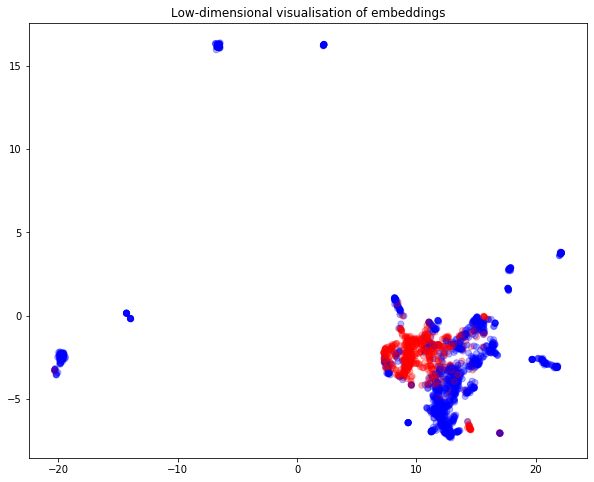

In [207]:
plot_embeddings(w2v_matrix,DO_PARAGRAPH_VECTOR, DO_BOW, DO_WORD2VEC, figures_path)

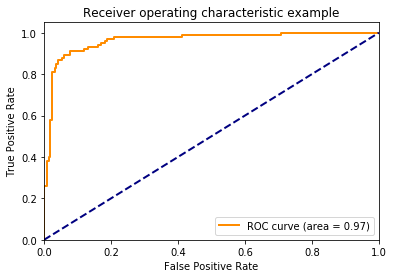

In [208]:
plot_AUC(fpr, tpr, roc_auc, DO_PARAGRAPH_VECTOR, DO_BOW, DO_WORD2VEC, figures_path)

In [183]:
accuracy

0.9348370927318296

# Sinai Method

In [184]:
# Slight modifications to swap out indexing in TF FP TN FN and the randomization process
def calc_auc(predictor_matrix,eligible_outcomes_aligned, all_outcomes_aligned,N_LABELS, pred_type, header,ASSIGNFOLD_USING_ROW=False):

    train_proportion = 0.6
    lasso_models={}
    model_types = ["Lasso"]

    # shuffle the data
    eligible_outcomes_aligned.reindex(np.random.permutation(eligible_outcomes_aligned.index)) # swapped out np.random.shuffle(r)

    r = list(range(eligible_outcomes_aligned.shape[0]))
    np.random.shuffle(r)

    assignfold = pd.DataFrame(data=r, columns=['train'])
    cutoff = np.floor(train_proportion*eligible_outcomes_aligned.shape[0]).astype(int)

    train=assignfold['train']<cutoff
    test=assignfold['train']>=cutoff

    print(test)
    N_TRAIN=eligible_outcomes_aligned.iloc[:cutoff].shape[0]
    N_HELDOUT = eligible_outcomes_aligned.iloc[cutoff:].shape[0]

    #train = eligible_outcomes_aligned.iloc[:cutoff,[0]]
    #test = eligible_outcomes_aligned.iloc[cutoff:,[0]]

    print("n_train in modeling="+str(N_TRAIN))
    print("n_test in modeling="+str(N_HELDOUT))

    confusion = pd.DataFrame(data=np.zeros(shape=(eligible_outcomes_aligned.shape[1]*len(model_types),6),dtype=np.int),columns=['Label (with calcs on held out 40 pct)','AUC','True +','False +','True -','False -'])

    resultrow=0

    for i in range(0,N_LABELS):
            PROCEED=True;
            #need to make sure we don't have an invalid setting -- ie, a train[x] set of labels that is uniform, else Lasso regression fails
            if(len(set(eligible_outcomes_aligned.ix[train,i].tolist())))==1:
                PROCEED=False;
                raise ValueError ("fed label to lasso regression with no variation - cannot compute - please investigate data")

            if(PROCEED):

                for model_type in model_types:
                    if(model_type=="Lasso"):
                        parameters = { "penalty": ['l1'], 
                                       "C": [64,32,16,8,4,2,1,0.5,0.25,0.1,0.05,0.025,0.01,0.005]
                                     }
                        try:
                            cv = StratifiedKFold(n_splits=5)
                            grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid=parameters, scoring='neg_log_loss', cv=cv) ## can change liblinear to "lbfgs"
                            grid_search.fit(predictor_matrix[train,:],np.array(eligible_outcomes_aligned.ix[train,i]))				
                            best_parameters0 = grid_search.best_estimator_.get_params()
                            model0 = LogisticRegression(**best_parameters0)					
                        except:
                            raise ValueError ("error in lasso regression - likely data issue, may involve rare labels - please investigate data")                        
                    model0.fit(predictor_matrix[np.array(train),:],eligible_outcomes_aligned.ix[train,i])
                    pred0 = model0.predict_proba(predictor_matrix[np.array(test),:])[:,1]
                    coef = pd.concat([ pd.DataFrame(headers),pd.DataFrame(np.transpose(model0.coef_))], axis = 1)	
                    df0 = pd.DataFrame({'predict':pred0,'target':eligible_outcomes_aligned.ix[test,i], 'label':all_outcomes_aligned['Accession Number'][test]})

                    calc_auc=roc_auc_score(np.array(df0['target']),np.array(df0['predict']))
                    if(i%10==0):
                        print("i="+str(i))
                    save_name=str(list(eligible_outcomes_aligned.columns.values)[i])

                    target_predicted=''.join(e for e in save_name if e.isalnum())

                    #confusion: outcome TP TN FP FN
                    thresh = np.mean(df0['target'])
                    FP=0
                    FN=0
                    TP=0
                    TN=0
                    
                    # Added for computing ROC curve and ROC area
                    fpr = dict()
                    tpr = dict()
                    roc_auc = dict()
                    
                    prediction_list = df0[[0]].tolist()
                    target_list = df0[[1]].tolist()
                    
                    
                    fpr[0], tpr[0], thresholds = roc_curve(target_list, prediction_list)
                    roc_auc[0] = auc(fpr[0], tpr[0])

                                       # Compute micro-average ROC curve and ROC area
                    fpr["micro"], tpr["micro"], _ = roc_curve(target_list.ravel(), prediction_list.ravel())
                    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

                    for j in df0.index:
                        cpred = df0.ix[j][0] # changed from 1 to 0 
                        ctarget = df0.ix[j][1] # changed from 2 to 1

                        
                        if cpred>=thresh and ctarget==1:
                            TP+=1
                        if cpred<thresh and ctarget==1:
                            FN+=1
                        if cpred>=thresh and ctarget==0:
                            FP+=1
                        if cpred<thresh and ctarget==0:
                            TN+=1

                        
 

                    
                    #save results		
                    confusion.iloc[resultrow,0]=list(eligible_outcomes_aligned.columns.values)[i]
                    confusion.iloc[resultrow,1]=calc_auc
                    confusion.iloc[resultrow,2]=TP
                    confusion.iloc[resultrow,3]=FP
                    confusion.iloc[resultrow,4]=TN
                    confusion.iloc[resultrow,5]=FN

                    #let's rebuild model using all data before we save it to use for prediction;
                    try:
                        model0 = LogisticRegression(**best_parameters0)	
                        model0.fit(predictor_matrix,eligible_outcomes_aligned.ix[:,i])                
                        lasso_models[i]=model0
                    except:
                        raise ValueError ("error in lasso regression - likely data issue, may involve rare labels - please investigate data")                        

                    resultrow+=1

    confusion.set_index(confusion.columns[0],inplace=True)
    return lasso_models, confusion, fpr, tpr, roc_auc

In [185]:
# Create the lasso model using the function defined above
lasso_models, accuracy, fpr, tpr, roc_auc = calc_auc(predictor_matrix, eligible_outcomes_aligned,all_outcomes_aligned,N_LABELS, pred_type,headers,ASSIGNFOLD_USING_ROW) 

0        True
1        True
2       False
3       False
4        True
        ...  
1987     True
1988    False
1989     True
1990    False
1991    False
Name: train, Length: 1992, dtype: bool
n_train in modeling=1195
n_test in modeling=797


c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\pandas\core\indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentatio

i=0


KeyError: "None of [Int64Index([0], dtype='int64')] are in the [columns]"

In [118]:
# Plot the ROC

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

0       False
1        True
2       False
3       False
4        True
        ...  
1150    False
1151     True
1152     True
1153    False
1154    False
Name: train, Length: 1155, dtype: bool
n_train in modeling=693
n_test in modeling=462


c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\pandas\core\indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\ipykernel_launcher.py:51: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentatio

i=0


c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\ipykernel_launcher.py:98: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


In [119]:
inferred_binary_labels, inferred_proba_labels = ra.write_silver_standard_labels(corpus,
                                                  N_LABELS,
                                                  eligible_outcomes_aligned, 
                                                  DIM_DOC2VEC, 
                                                  preprocessed, 
                                                  DO_BOW, 
                                                  DO_PARAGRAPH_VECTOR, 
                                                  DO_WORD2VEC, 
                                                  dictionary, 
                                                  d2vmodel, 
                                                  d2v_inputs, 
                                                  lasso_models_ra, 
                                                  accid_list, 
                                                  labeled_indices, 
                                                  df_raw_filter, 
                                                  SILVER_THRESHOLD)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]
C:\Users\marti\Dropbox\1. KCL\1. Current Modules\6. SPM\1. Analysis\NLP\rad-report-annotator\RadReportAnnotator.py:798: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if(eligible_outcomes_aligned.ix[outcome_lookup[accno],k]!=pred_outcome_binary_df.iloc[i,k]):
c:\users\marti\dropbox\15607~1.kcl\1c4ea~1.cur\6c9d3~1.spm\19e96~1.ana\nlp\lib\site-packages\pandas\core\indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
C:\Users\marti\Dropbox\1. KCL\1. 

In [120]:
lasso_models_ra
accuracy


,AUC,True +,False +,True -,False -
Label (with calcs on held out 40 pct),,,,,
Mass,0.959194,195,34,213,20


In [127]:
# 	def define_config(self, DO_BOW=True, DO_WORD2VEC=False, DO_PARAGRAPH_VECTOR=False,DO_SILVER_STANDARD=True,STEM_WORDS=True,N_GRAM_SIZES=[1],DIM_DOC2VEC=200,N_THRESH_CORPUS=1,N_THRESH_OUTCOMES=1,TRAIN_INDEX_OVERRIDE=[], SILVER_THRESHOLD="mean", NAME_UNID_REPORTS="Accession Number",NAME_TEXT_REPORTS="Report Text"):
# 		"""
# 		Sets parameters for RadReportAnnotator.
# 		Args:
# 			DO_BOW: True to use indicator bag of words-based features (1 if word present in doc, 0 if not). 
# 			DO_WORD2VEC: True to use word2vec-based average word embedding fatures. 
# 			DO_PARAGRAPH_VECTOR: True to use word2vec-based paragraph vector embedding fatures. 
# 			DO_SILVER_STANDARD: True to infer labels for unlabeled reports.
# 			STEM_WORDS: True to stem words for BOW analysis; words are unstemmed in doc2vec analysis
# 			N_GRAM_SIZES: Which set of n-grams to use in BOW analysis: [1] = 1 grams only, [3] = 3 grams only, [1,2,3] = 1, 2, and 3- grams.
# 			DIM_DOC2VEC: Dimensionality of doc2vec manifold; recommend value in 50 to 400
# 			N_THRESH_CORPUS: ignore any n-grams that appear fewer than N times in the entire corpus
# 			N_THRESH_OUTCOMES: do not train models for labels that don't have at least this many positive and negative examples. 
# 			TRAIN_INDEX_OVERRIDE: list of accession numbers we force to be treated as unlabeled data even though they are labeled (ie, these will *not* be used in Lasso regressions). May be used if all of your reports are labeled, as some unlabeled reports are required for d2v training.
# 			SILVER_THRESHOLD: how to threshold probability predictions in infer_labels to get binary labels. 
# 			                  can be ["mean","mostlikely"]
# 			                  mean sets any predicted probability greater than population mean to 1, else 0; e.g., prediction 0.10 in a label with average 0.05 is set to 1
# 			                  mostlikely sets any predicted probability >50% to 1, otherwise 0
# 			                  both settings have issues, and class imbalance is a major issue in training convolutional nets.
# 			                  we recommend using probabilities if your model can accomodate it. 
#  			NAME_UNID_REPORTS: column name of accession number / unique report id in the read-in *reports* file. provided for convenience as there may be many report files.
# 			NAME_TEXT_REPORTS: column name of report text in the read-in reports file. provided for convenience as there may be many report files.
# 		Returns:
# 			Nothing
# 		"""

# 		self.DO_BOW=DO_BOW #generate results for bag of words approach?
# 		self.DO_WORD2VEC=DO_WORD2VEC #generate resultes (tfidf and avg weight) for word2vec approach?
# 		self.DO_PARAGRAPH_VECTOR=DO_PARAGRAPH_VECTOR #generate results for paragraph vector approach?
# 		self.DO_SILVER_STANDARD=DO_SILVER_STANDARD	#generate silver standard labels?
# 		self.STEM_WORDS=STEM_WORDS #should we stem words for BOW, LDA analysis? (we never stem words or doc2vec/w2v analysis, see below)
# 		if not N_GRAM_SIZES in ([1],[2],[3],[1,2],[1,3],[1,2,3]):
# 			raise ValueError('Invalid N_GRAM_SIZES argument:'+str(N_GRAM_SIZES)+", please review documentation for proper format (e.g., [1])")
# 		self.N_GRAM_SIZES = N_GRAM_SIZES  # how many n-grams to use in BOW, LDA analyses? [1] = 1 grams only, [3] = 3 grams only, [1,2,3] = 1, 2, and 3- grams.
# 		self.DIM_DOC2VEC = DIM_DOC2VEC #dimensionality of doc2vec manifold
# 		self.N_THRESH_CORPUS=N_THRESH_CORPUS # delete any n-grams that appear fewer than N times in the entire corpus
# 		self.N_THRESH_OUTCOMES=N_THRESH_OUTCOMES # delete any predictors that don't have at least N-many positive and negative examples
# 		self.TRAIN_INDEX_OVERRIDE = TRAIN_INDEX_OVERRIDE # define a list of indices you want to force to be included as unlabeled data even though they are labeled (ie, these will *not* be used for predictions). Some unlabeled reports are required for d2v training."""
# 		self.SILVER_THRESHOLD=SILVER_THRESHOLD
# 		self.NAME_UNID_REPORTS = NAME_UNID_REPORTS  
# 		self.NAME_TEXT_REPORTS = NAME_TEXT_REPORTS

# 		if(self.DO_BOW==False and self.DO_WORD2VEC==False and self.DO_PARAGRAPH_VECTOR==False): raise ValueError("DO_BOW and DO_WORD2VEC and DO_PARAGRAPH_VECTOR cannot both be false")


In [129]:
# 	def infer_labels(self):
# 		"""
# 		Infers labels for unlabeled documents.
# 		Please run build_corpus() beforehand.
# 		Arguments:
# 			None
# 		Returns:
# 			self.inferred_labels: dataframe containing inferred labels
# 		"""

# 		#get the numerical features of text we need to train models for labels
# 		self.bow_matrix, self.pv_matrix,self.w2v_matrix,self.accid_list,self.orig_text,self.orig_input=generate_labeled_data_features(
# 							   self.validation_file,
# 							   self.labeled_indices,
# 							   self.DIM_DOC2VEC,
# 							   self.df_data,
# 							   self.processed_reports,
# 							   self.DO_PARAGRAPH_VECTOR,
# 							   self.DO_WORD2VEC, 
# 							   self.dictionary,
# 							   self.corpus,
# 							   self.d2vmodel,
# 							   self.d2v_inputs)

# 		#get and process labels for reports
# 		self.eligible_outcomes_aligned,self.all_outcomes_aligned, self.N_LABELS, self.outcome_header_list = generate_outcomes(
# 			self.validation_file,
# 			self.accid_list,
# 			self.N_THRESH_OUTCOMES)

# 		#to generate silver standard labels -- use whatever features are generated (word2vec average word embeddings, bow features, paragraph vector matrix)
# 		if(self.DO_BOW and self.DO_WORD2VEC and self.DO_PARAGRAPH_VECTOR): self.combined=np.hstack((self.bow_matrix,self.w2v_matrix,self.pv_matrix))

# 		if(self.DO_BOW and self.DO_WORD2VEC and not self.DO_PARAGRAPH_VECTOR): self.combined=np.hstack((self.bow_matrix,self.w2v_matrix))
# 		if(self.DO_BOW and not self.DO_WORD2VEC and self.DO_PARAGRAPH_VECTOR): self.combined=np.hstack((self.bow_matrix,self.pv_matrix))
# 		if(not self.DO_BOW and self.DO_WORD2VEC and self.DO_PARAGRAPH_VECTOR): self.combined=np.hstack((self.w2v_matrix,self.pv_matrix))

# 		if(self.DO_BOW and not self.DO_WORD2VEC and not self.DO_PARAGRAPH_VECTOR): self.combined=self.bow_matrix
# 		if(not self.DO_BOW and self.DO_WORD2VEC and not self.DO_PARAGRAPH_VECTOR): self.combined=self.w2v_matrix
# 		if(not self.DO_BOW and not self.DO_WORD2VEC and self. DO_PARAGRAPH_VECTOR): self.combined=self.pv_matrix		

# 		#create header for combined predictor matrix so we can interpret coefficients
# 		self.headers=[]
# 		if(self.DO_BOW): 				self.headers=self.headers + [self.dictionary[i] for i in self.dictionary]
# 		if(self.DO_WORD2VEC): 			self.headers=self.headers + ["W2V"+str(i) for i in range(0,self.DIM_DOC2VEC)]
# 		if(self.DO_PARAGRAPH_VECTOR): 	self.headers=self.headers + ["PV"+str(i) for i in range(0,self.DIM_DOC2VEC)]


# 		pred_type = "combined" # a label for results
# 		print("dimensionality of predictor matrix:"+str(self.combined.shape))

# 		#run lasso regressions
# 		self.lasso_models, self.accuracy = calc_auc(self.combined,self.eligible_outcomes_aligned,self.all_outcomes_aligned,  self.N_LABELS, pred_type, self.headers,self.ASSIGNFOLD_USING_ROW)

# 		#infer labels	
# 		self.inferred_binary_labels, self.inferred_proba_labels = write_silver_standard_labels(self.corpus,
# 			self.N_LABELS,
# 			self.eligible_outcomes_aligned,
# 			self.DIM_DOC2VEC,
# 			self.processed_reports,
# 			self.DO_BOW,
# 			self.DO_PARAGRAPH_VECTOR,
# 			self.DO_WORD2VEC,
# 			self.dictionary,
# 			self.d2vmodel,
# 			self.d2v_inputs,
# 			self.lasso_models,
# 			self.accid_list, 
# 			self.labeled_indices,
# 			self.df_data,
# 			self.SILVER_THRESHOLD)
# 		return self.inferred_binary_labels, self.inferred_proba_labels

In [130]:
# This works, but not as elegant

# if predictor_matrix.shape[1]!=len(header):
#     print("predictor_matrix.shape[1]="+str(predictor_matrix.shape[1]))
#     print("len(header)"+str(len(header)))
#     raise ValueError("predictor_matrix shape doesn't match header, investigate")
# all_coef = pd.concat([ pd.DataFrame(header)], axis = 1)	



# train_proportion = 0.6
# lasso_models={}
# model_types = ["Lasso"]

# # shuffle the data
# eligible_outcomes_aligned.reindex(np.random.permutation(eligible_outcomes_aligned.index)) # swapped out np.random.shuffle(r)

# r = list(range(eligible_outcomes_aligned.shape[0]))
# np.random.shuffle(r)

# assignfold = pd.DataFrame(data=r, columns=['train'])
# cutoff = np.floor(train_proportion*eligible_outcomes_aligned.shape[0]).astype(int)

# train=assignfold['train']<cutoff
# test=assignfold['train']>=cutoff

# print(test)
# N_TRAIN=eligible_outcomes_aligned.iloc[:cutoff].shape[0]
# N_HELDOUT = eligible_outcomes_aligned.iloc[cutoff:].shape[0]

# #train = eligible_outcomes_aligned.iloc[:cutoff,[0]]
# #test = eligible_outcomes_aligned.iloc[cutoff:,[0]]

# print("n_train in modeling="+str(N_TRAIN))
# print("n_test in modeling="+str(N_HELDOUT))

# confusion = pd.DataFrame(data=np.zeros(shape=(eligible_outcomes_aligned.shape[1]*len(model_types),6),dtype=np.int),columns=['Label (with calcs on held out 40 pct)','AUC','True +','False +','True -','False -'])

# resultrow=0
# i = 0

# parameters = { "penalty": ['l1'], 
#                "C": [64,32,16,8,4,2,1,0.5,0.25,0.1,0.05,0.025,0.01,0.005]}

# cv = StratifiedKFold(n_splits=5)
# grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid=parameters, scoring='neg_log_loss', cv=cv) ## can change liblinear to "lbfgs"
# grid_search.fit(predictor_matrix[train,:],np.array(eligible_outcomes_aligned.ix[train,i]))				
# best_parameters0 = grid_search.best_estimator_.get_params()
# model0 = LogisticRegression(**best_parameters0)					
                 
# model0.fit(predictor_matrix[np.array(train),:],eligible_outcomes_aligned.ix[train,i])
# pred0=model0.predict_proba(predictor_matrix[np.array(test),:])[:,1]
# coef = pd.concat([ pd.DataFrame(headers),pd.DataFrame(np.transpose(model0.coef_))], axis = 1)	
# df0 = pd.DataFrame({'predict':pred0,'target':eligible_outcomes_aligned.ix[test,i], 'label':all_outcomes_aligned['Accession Number'][test]})

# calc_auc=roc_auc_score(np.array(df0['target']),np.array(df0['predict']))
# save_name=str(list(eligible_outcomes_aligned.columns.values)[i])
# target_predicted=''.join(e for e in save_name if e.isalnum())

# # confusion: outcome TP TN FP FN
# thresh = np.mean(df0['target'])
# FP=0
# FN=0
# TP=0
# TN=0

# for j in df0.index:
#     cpred=df0.ix[j][0]
#     ctarget = df0.ix[j][1]

#     if cpred>=thresh and ctarget==1:
#         TP+=1
#     if cpred<thresh and ctarget==1:
#         FN+=1
#     if cpred>=thresh and ctarget==0:
#         FP+=1
#     if cpred<thresh and ctarget==0:
#         TN+=1
						
# #save results		
# confusion.iloc[resultrow,0]=list(eligible_outcomes_aligned.columns.values)[i]
# confusion.iloc[resultrow,1]=calc_auc
# confusion.iloc[resultrow,2]=TP
# confusion.iloc[resultrow,3]=FP
# confusion.iloc[resultrow,4]=TN
# confusion.iloc[resultrow,5]=FN
            
    
# model0 = LogisticRegression(**best_parameters0)	
# model0.fit(predictor_matrix,eligible_outcomes_aligned.ix[:,i])                
# lasso_models[i]=model0

# # resultrow+=1

# confusion.set_index(confusion.columns[0],inplace=True)
# # return lasso_models, confusion